In [1]:
import numpy as np
from scripts.mesh import *
from scripts.simulation import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

font = {'family' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (12,8)

In [2]:
def generate_degree_ratio(degree, low):
    if degree < 3:
        low = 1
    return np.random.uniform(low,1)
        
def generate_mesh_settings(grid_size):
    mesh_degree_settings = MESH_DEGREE_SETTINGS
    mesh_settings = MESH_SETTINGS
    
    mesh_settings['grid_size'] = grid_size
    mesh_settings['contraction_ratio'] = np.random.uniform(0,0.25)
    
    mesh_degree_settings[6] = generate_degree_ratio(6,0)
    mesh_degree_settings[5] = generate_degree_ratio(5,0)
    mesh_degree_settings[4] = generate_degree_ratio(4,0)
    mesh_degree_settings[3] = generate_degree_ratio(3,0.2)
#     mesh_degree_settings[2] = generate_degree_ratio(2,0.2)
    
    return mesh_settings

In [3]:
def mc_degree_impact(mesh,fail_rate,degree,valid_pids,num_sim = 100):
    pool = mp.Pool(mp.cpu_count()-1)
    results = pool.starmap(degree_impact, [(mesh,fail_rate,degree,valid_pids) for _ in range(num_sim)])
    pool.close()
    
    directs,unintends = [],[]
    for direct,unintend in results:
        directs.append(direct)
        unintends.append(unintend)
        
    return np.mean(directs)/len(valid_pids),np.mean(unintends)/len(valid_pids)

In [4]:
def multi_degree_impact(mesh,fail_rate,degree_list):
    degree_result = []
    for degree in degree_list:
        results = mc_degree_impact(mesh,fail_rate,degree,mesh.valid_pids,30)
        degree_result.append(results)
    return degree_result
    

In [5]:
fail_rate = 0.25
degree_list = list(range(1,10,2))
mc_num = 800
grid_size = 20

In [ ]:
mc_results = []
sparsity = []
num_sim = 0
while num_sim < mc_num:
    try:
        mesh_setting = generate_mesh_settings(grid_size)
        mesh = create_mesh(mesh_setting)
        sparseness = calculate_sparseness(mesh)
        print (f'sparseness of the created mesh (compare to the grid network) {sparseness}')
    except:
        continue
    result = multi_degree_impact(mesh,fail_rate,degree_list)
    mc_results.append(result) 
    sparsity.append(sparseness)
    num_sim+=1

sparseness of the created mesh (compare to the grid network) 0.42857142857142855
sparseness of the created mesh (compare to the grid network) 0.46938775510204084
sparseness of the created mesh (compare to the grid network) 0.23469387755102042


In [7]:
len(mc_results)

800

In [8]:
degree_list

[1, 3, 5, 7, 9]

In [9]:
direct_results = [[],[],[],[],[]]
unintend_results = [[],[],[],[],[]]
for result in mc_results:
    for i in range(len(degree_list)):
        direct_results[i].append(result[i][0])
        unintend_results[i].append(result[i][1])
        
    
    

In [10]:
direct_results

[[0.005359163591635916,
  0.004637583892617449,
  0.0056740088105726874,
  0.005076576576576576,
  0.004647820965842169,
  0.004647179487179487,
  0.003919701213818861,
  0.004492450638792104,
  0.004268343815513628,
  0.003939226519337016,
  0.004533564814814814,
  0.004760822510822512,
  0.004432098765432098,
  0.004978239366963403,
  0.004635752688172044,
  0.0042409909909909916,
  0.004740880503144654,
  0.004850938967136149,
  0.003886426592797784,
  0.004632183908045977,
  0.003976190476190476,
  0.004793464052287582,
  0.004890011223344556,
  0.005454545454545455,
  0.0046934404283801865,
  0.005687853107344634,
  0.004927437641723357,
  0.004182608695652174,
  0.005181938911022577,
  0.0054104308390022695,
  0.004969387755102041,
  0.004631693989071039,
  0.0058125,
  0.004784136546184739,
  0.004507194244604317,
  0.005177002583979328,
  0.00489437585733882,
  0.0042130801687763715,
  0.005974926253687315,
  0.004872960372960374,
  0.004849999999999999,
  0.0041449704142011825

In [11]:
def plot_mc_multi_consequence(sparsity,direct,unintend,degree):
    plt.scatter(sparsity, direct, label="direct")
    plt.scatter(sparsity, unintend, label="unintend")
    plt.title(f'Consequence of isolate {degree} pipes')
    plt.xlabel('meshness')
    plt.ylabel('Avg impact ratio')
    plt.legend()
    plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


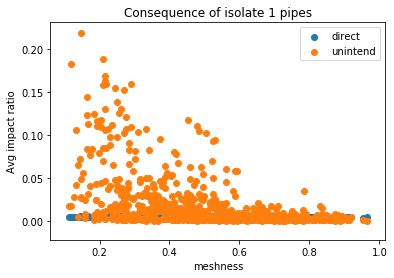

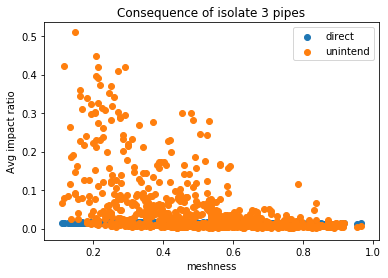

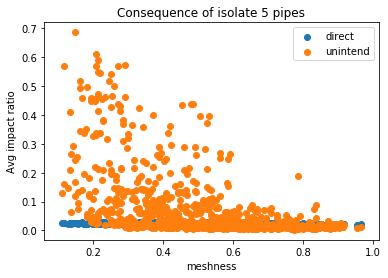

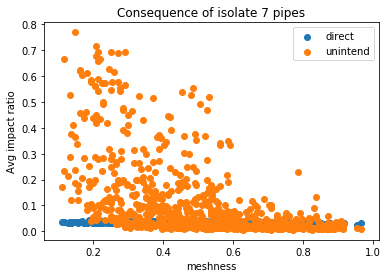

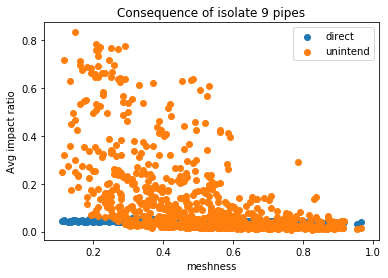

In [12]:
for i in range(len(degree_list)):
    plot_mc_multi_consequence(sparsity,direct_results[i],unintend_results[i],degree_list[i])

In [13]:
def get_sp_degree(sparsity,num_class = 10):
    interval = 1/num_class
    for i in range(num_class):
        if sparsity<interval*(i+1):
            return i

def create_consequence_df(sparsity,direct,unintend):
    conse_type = len(direct)*['direct']+len(unintend)*['unintend']
    sparsities = sparsity+sparsity
    sparsity_degree = [get_sp_degree(sp) for sp in sparsities]
    df_dict = {
        'sparsity':sparsities,
        'mesh_degree':sparsity_degree,
        'consequence':direct+unintend,
        'type':conse_type
    }
    return pd.DataFrame.from_dict(df_dict)

In [14]:
df1 = create_consequence_df(sparsity,direct_results[i],unintend_results[i])

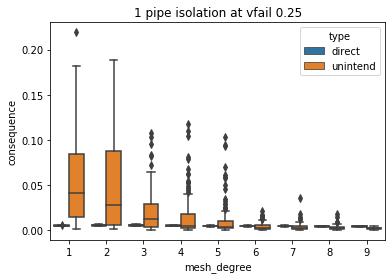

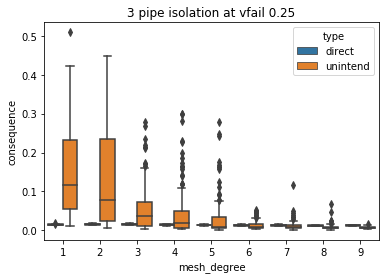

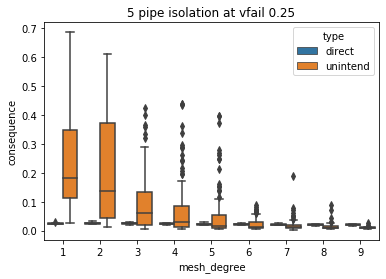

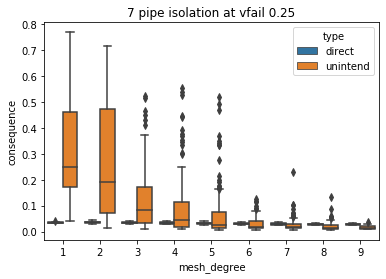

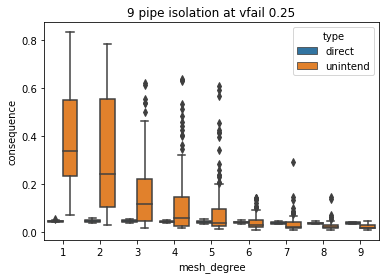

In [15]:
# plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
for i,k in enumerate(degree_list):
    fig = plt.figure()
    df = create_consequence_df(sparsity,direct_results[i],unintend_results[i])
    ax = sns.boxplot(x="mesh_degree", y="consequence", hue="type",
                    data=df).set_title(f'{k} pipe isolation at vfail 0.25')

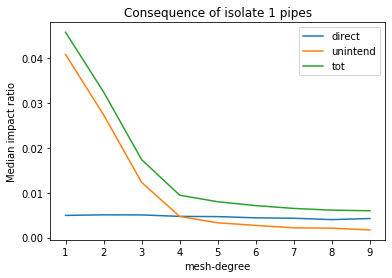

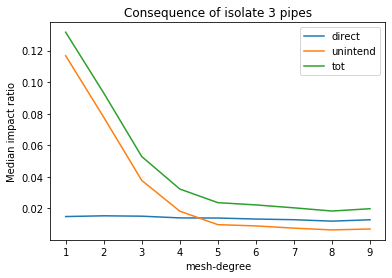

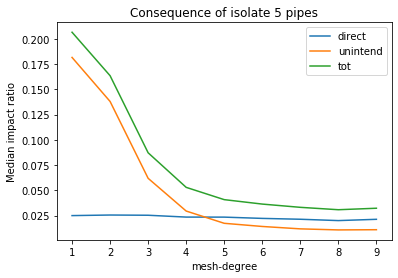

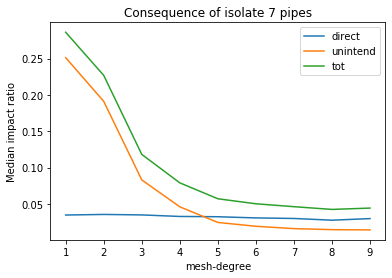

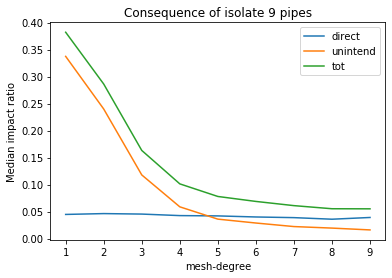

In [16]:
for i,k in enumerate(degree_list):
    fig = plt.figure()
    df = create_consequence_df(sparsity,direct_results[i],unintend_results[i])
    df_direct = df[df['type'] == 'direct'].groupby('mesh_degree', as_index=False).median()
    df_unintend = df[df['type'] == 'unintend'].groupby('mesh_degree', as_index=False).median()
    
    plt.plot(df_direct['mesh_degree'], df_direct['consequence'], label="direct")
    plt.plot(df_unintend['mesh_degree'], df_unintend['consequence'], label="unintend")
    plt.plot(df_unintend['mesh_degree'], df_direct['consequence']+df_unintend['consequence'], 
             label="tot")
    plt.title(f'Consequence of isolate {k} pipes')
#     plt.bar(pids2sim, direct_ratio+unintend_ratio, label="tot")
    
    plt.xlabel('mesh-degree')
    plt.ylabel('Median impact ratio')
    plt.legend()
    plt.show()

#     ax = sns.pointplot(x='sparsity_degree', y='consequence',
#                        data=df_direct)
#     ax = sns.pointplot(x='sparsity_degree', y='consequence',
#                        data=df_unintend.groupby('sparsity_degree', as_index=False).median(),ax = ax)